# GEX preprocessing for PPI inference

This notebook will work on the filtered single-cell gene expression data from Mahdessian et al. to define appropriate edge costs and node prizes for the Prize-collecting Steiner analyses.

---

## 0. Environmental setup

In [628]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_unweighted
import venn
import networkx as nx
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_1samp, pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import mutual_info_score

seed = 1234

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [479]:
def find_markers(data, target, avg_log_fc=0.25, min_pct=0.1):
    target_data = data.loc[target]
    other_data = data.drop([target], axis=0)
    results = {
        "log_expr_target": [],
        "avg_log_expr_other": [],
        "log_fc": [],
        "pval": [],
    }
    genes = list(data.columns)
    selected_genes = []
    for gene in genes:
        log_other_expr = np.array(other_data.loc[:, gene])
        avg_log_expr_other = log_other_expr.mean()
        log_expr_target = target_data.loc[gene]
        log_fc = log_expr_target - avg_log_expr_other
        if log_fc > avg_log_fc and np.mean(log_other_expr == 0) <= (1 - min_pct):
            results["log_expr_target"].append(log_expr_target)
            results["avg_log_expr_other"].append(avg_log_expr_other)
            results["log_fc"].append(log_fc)
            results["pval"].append(ttest_1samp(log_other_expr, log_expr_target)[1])
            selected_genes.append(gene)
    results["fdr"] = fdrcorrection(results["pval"])[1]
    results = pd.DataFrame.from_dict(results)
    results.index = selected_genes
    return results

<IPython.core.display.Javascript object>

In [480]:
def search_for_confidence_cutoff(ppi, targets, uncertainty="cost"):
    n_edges = []
    avg_degrees = []
    n_nodes = []
    n_targets = []
    cutoffs = list(np.arange(0, 1, 0.001))
    ppi_edge_list = nx.to_pandas_edgelist(ppi)
    for cutoff in tqdm(cutoffs):
        graph = nx.from_pandas_edgelist(
            ppi_edge_list.loc[ppi_edge_list["cost"] < cutoff, :],
        )
        n_edges.append(len(graph.edges()))
        n_nodes.append(len(graph.nodes()))
        n_targets.append(len((targets).intersection(set(list((graph.nodes()))))))
        degrees = [val for (node, val) in graph.degree()]
        if len(graph.nodes()) > 0:
            avg_degrees.append(sum(degrees) / len(graph.nodes()))
        else:
            avg_degrees.append(0)
    edge_cost_overview = pd.DataFrame.from_dict(
        {
            "cutoff": cutoffs,
            "n_nodes": n_nodes,
            "n_targets": n_targets,
            "n_edges": n_edges,
            "avg_degree": avg_degrees,
        }
    )
    return edge_cost_overview

<IPython.core.display.Javascript object>

In [593]:
def compute_bootstrap_p(x, y, metric, b=1000, random_state=1234):
    np.random.seed(random_state)
    bootstrap_metrics = []
    if metric == "pearson":
        sample_metric = pearsonr(x, y)[0]
    elif metric == "spearman":
        sample_metric = spearmanr(x, y)[0]
    else:
        raise NotImplementedError("Unknown metric provided: {}".format(metric))
    for i in range(b):
        x_boot = np.random.choice(x, size=len(x), replace=True)
        y_boot = np.random.choice(y, size=len(y), replace=True)
        if metric == "pearson":
            bootstrap_metric = pearsonr(x_boot, y_boot)[0]
        elif metric == "spearman":
            bootstrap_metric = spearmanr(x_boot, y_boot)[0]
        else:
            raise NotImplementedError("Unknown metric provided: {}".format(metric))
        bootstrap_metrics.append(bootstrap_metric)
    p_boot = (1 / b) * np.sum(bootstrap_metrics <= sample_metric)
    return p_boot

<IPython.core.display.Javascript object>

In [ ]:
def compute_mi_score(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [751]:
def compute_edge_weights(
    ppi,
    data,
    metrics=["pearsonr", "spearmanr", "mi", "pearsonp", "spearmanp", "mip"],
    b=1000,
    random_state=1234,
):
    for metric in metrics:
        for (u, v) in tqdm(
            ppi.edges(), desc="Compute edge weights for {}".format(metric)
        ):
            x = np.array(data.loc[:, u])
            y = np.array(data.loc[:, v])
            if metric == "pearsonr":
                association = pearsonr(x, y)[0]
                cost = 1 - np.abs(association)
            elif metric == "spearmanr":
                association = spearmanr(x, y)[0]
                cost = 1 - np.abs(association)
            elif metric == "mi":
                cost = compute_mi_score(x, y, 100)
            elif metric == "pearsonp":
                association = compute_bootstrap_p(
                    x, y, metric="pearson", b=b, random_state=random_state
                )
                cost = association
            elif metric == "spearmanp":
                association = compute_bootstrap_p(
                    x, y, metric="spearman", b=b, random_state=random_state
                )
                cost = association
            elif metric == "mip":
                cost = -1
            else:
                raise NotImplementedError("Unknown metric provided: {}".format(metric))
            ppi.edges[u, v][metric] = cost
    return ppi

<IPython.core.display.Javascript object>

---

## 1. Read in data

We will read in a number of different data sets that we will use for our analyses: a) the single-cell gene expression data from Mahdessian et al. (2021), b) the most recent version of the CCLE expression data set, c) the list of ORF gene targets from the study by Rohban et al. (2017) and finally d) the Human PPI network as defined by the iRefIndexDB v14.

In [482]:
fucci_adata = sc.read("../../data/gex/fucci_adata.h5")
fucci_adata.var_names_make_unique()
fucci_data = pd.DataFrame(
    fucci_adata.X, columns=fucci_adata.var_names, index=fucci_adata.obs_names
)
fucci_data.columns = [c.upper() for c in fucci_data.columns]
fucci_data.head()

,TSPAN6,DPM1,SCYL3,C1ORF112,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,...,NOTCH2NLR,SPDYE14,DERPC,BMS1P23,LOC107986257,LOC728392,NOTCH2NLC,SPDYE11,ARMCX5-GPRASP2,LOC114841035
A10_355,4.084212,4.450537,2.539949,3.306074,0.0,3.924660,2.747193,3.980721,3.192863,3.306074,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,3.111745,0.000000,0.0,0.0
A10_356,4.416176,3.408068,0.000000,3.341437,0.0,3.109879,3.637463,2.683064,2.919073,4.264037,...,0.000000,0.0,2.540241,2.038441,1.584074,0.0,0.328890,1.336015,0.0,0.0
A10_357,2.784883,4.266762,0.000000,3.756405,0.0,4.676425,4.027002,4.154050,3.560914,4.211993,...,3.527433,0.0,3.144496,0.000000,0.000000,0.0,3.733050,0.000000,0.0,0.0
A11_355,3.995154,4.196535,1.325398,3.543870,0.0,3.015254,3.015254,4.159373,0.000000,3.481722,...,0.000000,0.0,3.219861,1.930217,0.000000,0.0,2.597980,1.435097,0.0,0.0
A11_356,5.384314,3.358004,2.851447,2.519226,0.0,4.309559,3.807653,3.807653,3.843228,3.843228,...,0.000000,0.0,3.926349,0.000000,0.000000,0.0,0.000000,1.948682,0.0,0.0


<IPython.core.display.Javascript object>

In [483]:
fucci_gene_set = set(fucci_data.columns)

<IPython.core.display.Javascript object>

The single-cell gene expression data from MAhdessian et al. (2021) to which we in the following refer to as FUCCI data set consists of 1'126 cells a 21'445.

In [484]:
ccle_data = pd.read_csv("../../data/gex/CCLE_expression.csv", index_col=0)
ccle_sample_info = pd.read_csv(
    "../../data/gex/CCLE_expression_sample_info.csv", index_col=0
)
matched_ids = set(ccle_sample_info.index).intersection(ccle_data.index)
ccle_data = ccle_data.loc[list(matched_ids)]
ccle_data.index = ccle_sample_info.loc[ccle_data.index, "stripped_cell_line_name"]
ccle_data.columns = [c.split(" ")[0].upper() for c in ccle_data.columns]
ccle_data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1ORF112,FGR,CFH,FUCA2,GCLC,NFYA,...,ARHGAP11B,AC004593.2,AC090517.4,AL160269.1,ABCF2-H2BE1,POLR2J3,H2BE1,AL445238.1,GET1-SH3BGR,AC113348.1
stripped_cell_line_name,,,,,,,,,,,,,,,,,,,,,
PA1,6.319401,1.130931,7.250867,2.336283,4.356848,0.028569,0.097611,6.041769,4.078097,4.105175,...,1.580145,0.084064,0.042644,0.000000,0.000000,4.431623,0.000000,0.042644,0.422233,0.000000
NCIH522,5.980711,0.000000,6.694741,2.643856,4.342697,0.070389,0.014355,0.604071,4.841973,4.702658,...,1.673556,0.028569,0.111031,0.536053,2.899176,3.619413,0.000000,0.000000,0.226509,0.014355
OVCAR4,4.947199,0.201634,6.754353,1.599318,3.694880,0.014355,0.632268,4.953265,3.763412,3.519793,...,1.405992,0.226509,0.056584,0.028569,3.075533,6.315965,0.000000,0.000000,1.207893,0.000000
MKN1,4.614121,0.000000,8.070443,2.356144,4.105175,1.641546,0.344828,6.004501,4.624686,4.126808,...,1.137504,0.176323,0.097611,0.084064,3.888500,6.539779,0.000000,0.097611,0.163499,0.000000
REC1,0.545968,0.000000,5.832131,3.247928,3.442280,3.988230,0.137504,0.344828,4.867402,4.477677,...,1.744161,0.000000,0.000000,0.000000,4.043519,5.456149,0.084064,0.000000,0.411426,0.000000


<IPython.core.display.Javascript object>

In [485]:
ccle_gene_set = set(ccle_data.columns)

<IPython.core.display.Javascript object>

The second data set from the CCLE study consist of 1'378 cancer cell lines for which we obtain the expression of roughly 19'177 genes.

In [486]:
orf_targets = set(
    pd.read_csv("../../data/gex/gene_target_list.txt", index_col=0, header=None).index
)

<IPython.core.display.Javascript object>

In [497]:
ppi_file = "../../data/ppi/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
iref_ppi = nx.convert_matrix.from_pandas_edgelist(
    pd.read_csv(ppi_file, sep="\t"),
    source="protein1",
    target="protein2",
    edge_attr="cost",
)
iref_ppi.remove_edges_from(nx.selfloop_edges(iref_ppi))

<IPython.core.display.Javascript object>

In [498]:
ppi_gene_set = set(list(iref_ppi.nodes()))

<IPython.core.display.Javascript object>

The Venn diagram below shows the overlap of the two gene sets with the 190 ORF targets from the study by Rohban et al. (2017) as well as with the ones from iRefIndexDB v14. That we will use later on as a basis to derive the interactome specific to the U2OS cells.

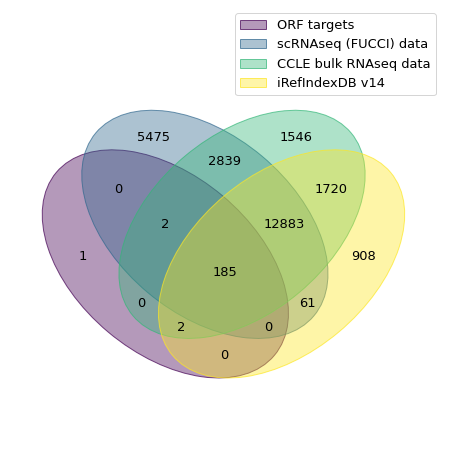

<IPython.core.display.Javascript object>

In [499]:
ax = venn.venn(
    dict(
        zip(
            [
                "ORF targets",
                "scRNAseq (FUCCI) data",
                "CCLE bulk RNAseq data",
                "iRefIndexDB v14",
            ],
            [
                orf_targets,
                fucci_gene_set,
                ccle_gene_set,
                ppi_gene_set,
            ],
        )
    )
)

Going forward, we will focus on the intersection of the genes that are covered in the scRNAseq (FUCCI) data set, the CCLE bulk RNAseq data set and the iRefIndexDB v14. While we will have not yet decided to use the bulk-sequencing data restricting us to those genes also covered by this gene expression data set only removes 61 genes including four known transcription factors (NFE4, ZNF286B, ZNF658B, ZNF702P) transcription factor nor any of the ORF targets, which are shown below.

In [500]:
human_tfs = set(
    list(
        pd.read_csv("../../data/gex/human_tf_list.txt", index_col=0, header=None).index
    )
)

<IPython.core.display.Javascript object>

In [501]:
(
    fucci_gene_set.intersection(ppi_gene_set)
    - set(fucci_data.columns).intersection(ppi_gene_set).intersection(ccle_gene_set)
).intersection(human_tfs)

{'NFE4', 'ZNF286B', 'ZNF658B', 'ZNF702P'}

<IPython.core.display.Javascript object>

In [677]:
selected_gene_set = fucci_gene_set.intersection(ppi_gene_set).intersection(
    ccle_gene_set
)
len(selected_gene_set)

13068

<IPython.core.display.Javascript object>

---

## 2. Identification of U2OS gene set

In total we have 13'068 genes that we selected for further analyses. However, we have to yet identify those that are particularly important in the functional and thus regulatory programs of our cell type: human osteosarcoma (U2OS) cells.

### 2a. Filtering out lowly expressed genes

First, we are interested in finding those genes that are highly expressed in the given cell type to this end, we will first plot the average gene expression for each individual gene of our scRNA-seq data set for the subset of genes that we selected as discussed previously. For better visualization we will order them according to their mean expression.

In [694]:
selected_fucci_data = fucci_data.loc[:, selected_gene_set]
mean_expression = selected_fucci_data.mean().sort_values(ascending=False)
median_expression = selected_fucci_data.median().sort_values(ascending=False)

<IPython.core.display.Javascript object>

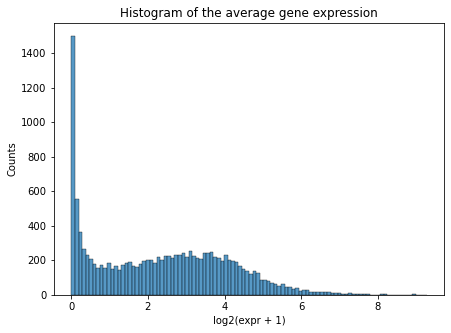

<IPython.core.display.Javascript object>

In [692]:
plt.figure(figsize=[7, 5])
sns.histplot(x=np.array(mean_expression), bins=100)
plt.title("Histogram of the average gene expression")
plt.xlabel("log2(expr + 1)")
plt.ylabel("Counts")
plt.show()

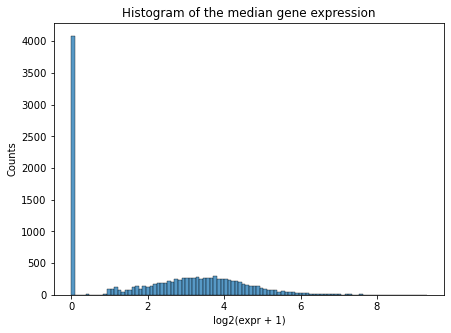

<IPython.core.display.Javascript object>

In [695]:
plt.figure(figsize=[7, 5])
sns.histplot(x=np.array(median_expression), bins=100)
plt.title("Histogram of the median gene expression")
plt.xlabel("log2(expr + 1)")
plt.ylabel("Counts")
plt.show()

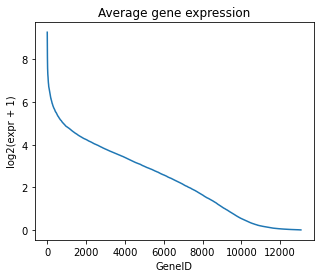

<IPython.core.display.Javascript object>

In [693]:
plt.figure(figsize=[5, 4])
plt.plot(list(range(len(mean_expression))), np.array(mean_expression))
plt.title("Average gene expression")
plt.ylabel("log2(expr + 1)")
plt.xlabel("GeneID")
plt.show()

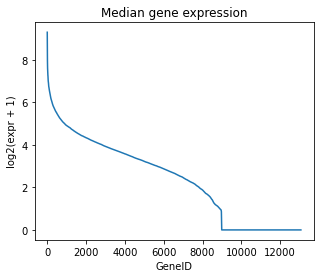

<IPython.core.display.Javascript object>

In [697]:
plt.figure(figsize=[5, 4])
plt.plot(list(range(len(median_expression))), np.array(median_expression))
plt.title("Median gene expression")
plt.ylabel("log2(expr + 1)")
plt.xlabel("GeneID")
plt.show()

The empirical distribution of the average gene expression seems to follow roughly a bi-modal distribution. Going forward we are less interested in genes that are very lowly expressed. The intuition is that a) for genes that are low expressed there is greater level of measurement noise (Sha et al., 2015) and b) these are expected to play a less important role in the functional regulation of the cell.

Thus, we will filter out such lowly expressed genes which we define as those with being predicted to be part of the background distribution that is of the component with smaller mean of a two-component Gaussian mixture model that we fit to the average gene expression values.

In [681]:
gmm = GaussianMixture(n_components=2, random_state=seed)
fitted_gmm = gmm.fit(np.array(mean_expression).reshape(-1, 1))
preds = fitted_gmm.predict(np.array(mean_expression).reshape(-1, 1))
pred_labels = []
for pred in preds:
    if pred == 0:
        pred_labels.append("low expressed")
    else:
        pred_labels.append("other")

<IPython.core.display.Javascript object>

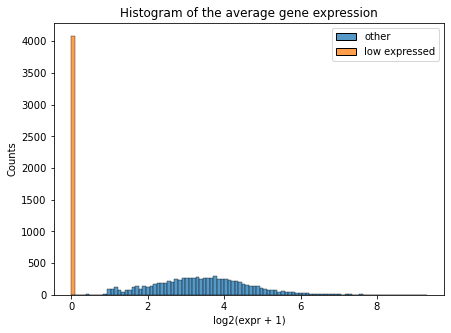

<IPython.core.display.Javascript object>

In [682]:
plt.figure(figsize=[7, 5])
sns.histplot(x=np.array(mean_expression), bins=100, hue=pred_labels)
plt.title("Histogram of the average gene expression")
plt.xlabel("log2(expr + 1)")
plt.ylabel("Counts")
plt.show()

In [698]:
gmm = GaussianMixture(n_components=2, random_state=seed)
fitted_gmm = gmm.fit(np.array(median_expression).reshape(-1, 1))
preds = fitted_gmm.predict(np.array(median_expression).reshape(-1, 1))
pred_labels = []
for pred in preds:
    if pred == 0:
        pred_labels.append("low expressed")
    else:
        pred_labels.append("other")

<IPython.core.display.Javascript object>

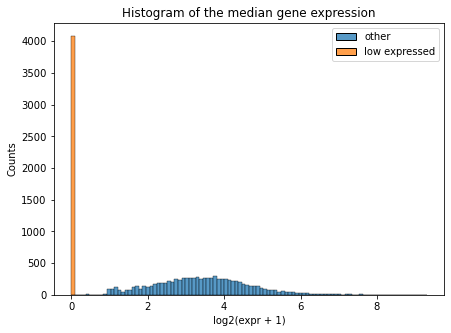

<IPython.core.display.Javascript object>

In [699]:
plt.figure(figsize=[7, 5])
sns.histplot(x=np.array(median_expression), bins=100, hue=pred_labels)
plt.title("Histogram of the median gene expression")
plt.xlabel("log2(expr + 1)")
plt.ylabel("Counts")
plt.show()

We estimate a cutoff for the mean gene expression that has been log+1-transformed after scaling to each gene expression profile to unit length for each cell to account for varying sequencing depth of 0.3417. 

In [683]:
avg_gex_threshold = (np.array(mean_expression)[preds == 0]).max()
avg_gex_threshold

0.0

<IPython.core.display.Javascript object>

In [686]:
background_genes = set(mean_expression.loc[mean_expression <= avg_gex_threshold].index)
foreground_genes = set(mean_expression.loc[mean_expression > avg_gex_threshold].index)
len(background_genes), len(foreground_genes)

(4084, 8984)

<IPython.core.display.Javascript object>

Thereby, we remove 2590 genes that we classify as lowly expressed among which are 276 human transcription factors.

In [687]:
len(background_genes.intersection(human_tfs))

543

<IPython.core.display.Javascript object>

We are thus left with 10'478 genes after that filtering step including 1'162 transcription factors and 177/190 ORF targets.

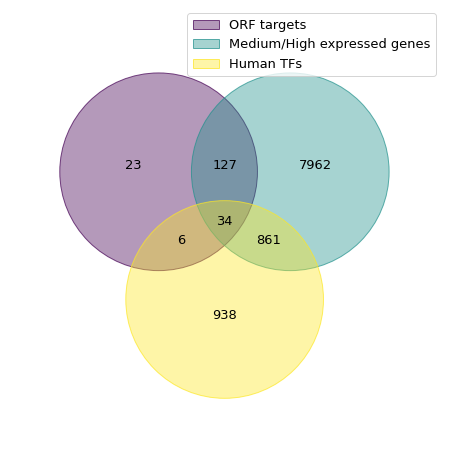

<IPython.core.display.Javascript object>

In [688]:
ax = venn.venn(
    dict(
        zip(
            ["ORF targets", "Medium/High expressed genes", "Human TFs"],
            [orf_targets, foreground_genes, human_tfs],
        )
    )
)

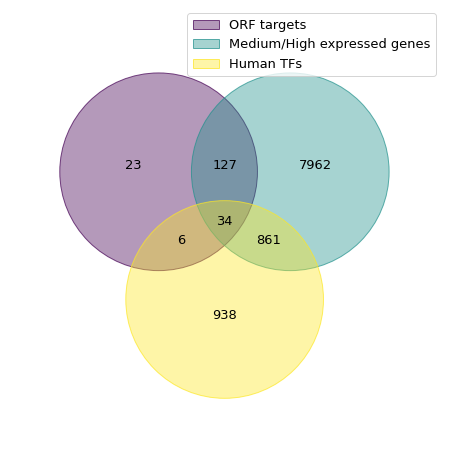

<IPython.core.display.Javascript object>

In [701]:
median_foreground = set(median_expression.loc[median_expression > 0].index)
median_background = set(median_expression.loc[median_expression <= 0].index)
ax = venn.venn(
    dict(
        zip(
            ["ORF targets", "Medium/High expressed genes", "Human TFs"],
            [orf_targets, median_foreground, human_tfs],
        )
    )
)

However, when having a closer look at the ORF targets that were identified to be background genes based on their low expression, we find that e.g. CEBPA (avg. log-expr: 0.08453) is among them which showed a drastic change in the cellular morphology upon over-expression. We would not want exclude such genes from our analyses.

We could pursue an approach where we only remove low-expressed genes that are not ORF targets, however it is likely that expression of these are co-regulated with certain other genes that upon over-expression lead to the drastic morphological changes. Thus, it might be desirable to include also low-expressed genes in the analyses to not also capture important signaling pathways that are turned off in wildtype U2OS cells but lead to significant structural changes in the cell upon activation via overexpression.

In [702]:
orf_targets.intersection(median_background)

{'AXIN2',
 'BAMBI',
 'BMP2',
 'BMPR1B',
 'CEBPA',
 'CXXC4',
 'DEPTOR',
 'DKK1',
 'DLL1',
 'ERG',
 'FGFR3',
 'FOXO1',
 'GLI1',
 'JAK2',
 'MAP3K5',
 'MAP3K8',
 'MAPK13',
 'MKNK1',
 'PHLPP1',
 'PPARGC1A',
 'SMAD7',
 'TNFAIP3',
 'VEGFC',
 'WNT5A'}

<IPython.core.display.Javascript object>

---

### 2b. Identification of U2OS marker genes

The set of genes that we identified as not being moderately expressed in U2OS cells forms one possible subset of genes of interest for the derivation of the cell-type specific interactome.

One alternative approach is to define a marker gene set for the given cell type by finding those genes that are significantly overexpressed in U2OS cell compared to other cell types. To identify such a set we will focus on the CCLE data spanning over 1300 different cancer cell lines. Note that this will likely lead to a selection of genes that are highly specific to that cell type due to the comparison to other cancer cell lines only.

To identify a the markers, we will run a screen testing for every gene if the mean expression of all other cancer cell lines is significantly smaller than the expression of that respective gene for U2OS cells using the bulk RNAseq data. In particular, we will test the following for each gene:

$$
H_A: \quad \bar{x}_i < x_{i,U2OS}, \quad \textrm{with} \ \bar{x}_i=\frac{1}{N-1}\sum\limits_{j\neq U2OS}x_{i,j}
$$
where $x_{i,j}$ is the transformed expression of gene $i$ in cell type $j$.

In [666]:
marker_results = find_markers(
    ccle_data,
    target="U2OS",
    avg_log_fc=0.0,
    min_pct=0,
)

<IPython.core.display.Javascript object>

In [667]:
marker_results.loc[(marker_results["fdr"] < 0.05)].sort_values(
    "log_fc", ascending=False
)

,log_expr_target,avg_log_expr_other,log_fc,pval,fdr
DHRS2,10.913937,2.265074,8.648862,0.000000e+00,0.000000e+00
TUBA3C,8.172977,0.363201,7.809776,0.000000e+00,0.000000e+00
XAGE1B,9.351337,1.736868,7.614469,0.000000e+00,0.000000e+00
PAGE2,7.891055,0.447193,7.443861,0.000000e+00,0.000000e+00
PAGE2B,7.760687,0.404266,7.356420,0.000000e+00,0.000000e+00
...,...,...,...,...,...
SMIM21,0.014355,0.007807,0.006548,1.162283e-09,1.327671e-09
PIWIL3,0.028569,0.022119,0.006450,3.728848e-02,3.900598e-02
GOLGA6L6,0.014355,0.008126,0.006230,4.286195e-02,4.476221e-02
HEATR9,0.028569,0.022395,0.006174,9.802144e-03,1.037052e-02


<IPython.core.display.Javascript object>

When we look at the log-fold changes of those genes that are overexpressed in U2OS cells compared to the other cell lines we find that those are decaying exponentially.

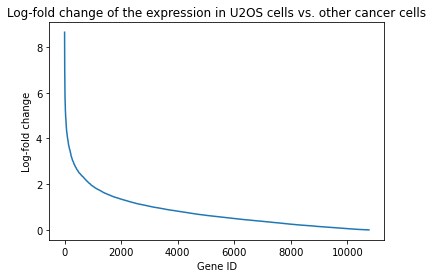

<IPython.core.display.Javascript object>

In [713]:
plt.figure()
plt.plot(
    list(range(len(marker_results))),
    np.array(marker_results.sort_values("log_fc", ascending=False).loc[:, "log_fc"]),
)
plt.ylabel("Log-fold change")
plt.xlabel("Gene ID")
plt.title("Log-fold change of the expression in U2OS cells vs. other cancer cells")
plt.show()

When looking at the plot of the distribution of the log-fold change of the expression in U2OS cells, we see that it levels off after approx. 1'000 of the most overexpressed genes in U2OS cells. We propose to conservatively choose those genes that are overexpressed with a log-fold change of at least 1 in U2OS cells compared to other cancer cell lines from the CCLE.

However, when we look at the log-fold change of the ORF targets, we see that many of these show a log-fold change below 1 and many of these however show an important structural response when overexpressed by ORF constructs like CASP8 which is highly toxic upon overexpression.

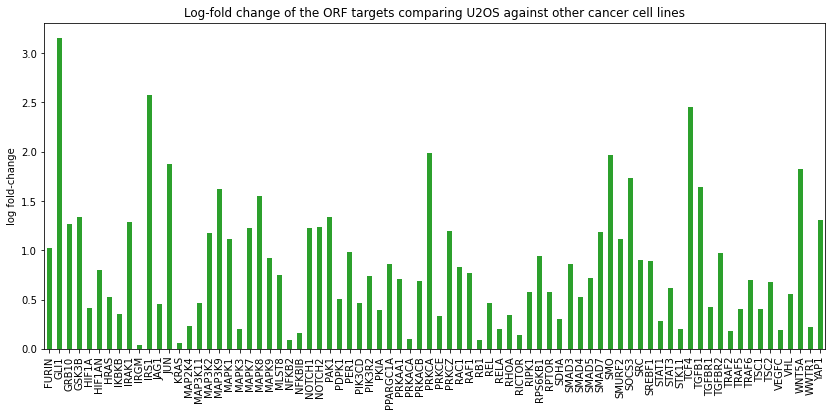

<IPython.core.display.Javascript object>

In [717]:
orf_log_fc = marker_results.loc[
    set(list(marker_results.index)).intersection(orf_targets), "log_fc"
]
orf_log_fc.sort_index().iloc[52:].plot.bar(figsize=[14, 6], color="tab:green")
plt.ylabel("log fold-change")
plt.title(
    "Log-fold change of the ORF targets comparing U2OS against other cancer cell lines"
)
plt.show()

Thus, we suggest to add all ORF targets covered by the scRNA-seq and iRefIndexDB v14 to those genes that are overexpressed with a log-fold change of at least 1.

This set of genes importantly includes 103/190 ORF targets and 730/1839 known transcripton factors. 87 ORF targets including 17 transcription factors are not selected.

In [670]:
selected_gene_set = set(marker_results.loc[marker_results["log_fc"] >= 1].index)
selected_gene_set = (
    (selected_gene_set.union(orf_targets))
    .intersection(fucci_gene_set)
    .intersection(ppi_gene_set)
)
len(selected_gene_set)

2753

<IPython.core.display.Javascript object>

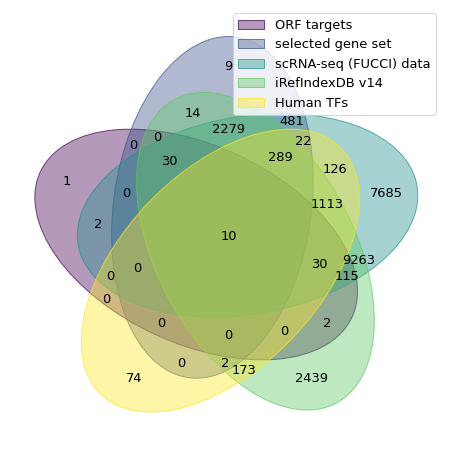

<IPython.core.display.Javascript object>

In [571]:
ax = venn.venn(
    dict(
        zip(
            [
                "ORF targets",
                "selected gene set",
                "scRNA-seq (FUCCI) data",
                "iRefIndexDB v14",
                "Human TFs",
            ],
            [
                orf_targets,
                selected_gene_set,
                fucci_gene_set,
                ppi_gene_set,
                human_tfs,
            ],
        )
    )
)

The selected gene set consists of 2'753 genes including 329 human transcription factor and 185 of the ORF targets (only not including CSNK1E, IRGM, MEK1 and PRKACG).

---

## 3. Preprocessing the PPI

In the following we will prune the PPI to remove low-confidence edges and respective disconnected components. To this end, we first aim to find a cut-off for the given edge costs that correspond to a measure of uncertainty for the existance of an interaction in the PPI between any pair of nodes.

The plots below illustrate the number of nodes, number of edges the average degree and the number of covered ORF targets for different cutoff values for the certainty of the respective edges of the subgraph of the human PPI induced by selecting only those gene covered by the scRNA-seq data set.

In [520]:
filtered_ppi = iref_ppi.subgraph(fucci_gene_set)
print(nx.info(filtered_ppi))

Name: 
Type: Graph
Number of nodes: 13129
Number of edges: 154269
Average degree:  23.5005


<IPython.core.display.Javascript object>

In [521]:
confidence_cutoff_search_results = search_for_confidence_cutoff(
    filtered_ppi, targets=orf_targets
)

100%|██████████| 1000/1000 [01:42<00:00,  9.78it/s]


<IPython.core.display.Javascript object>

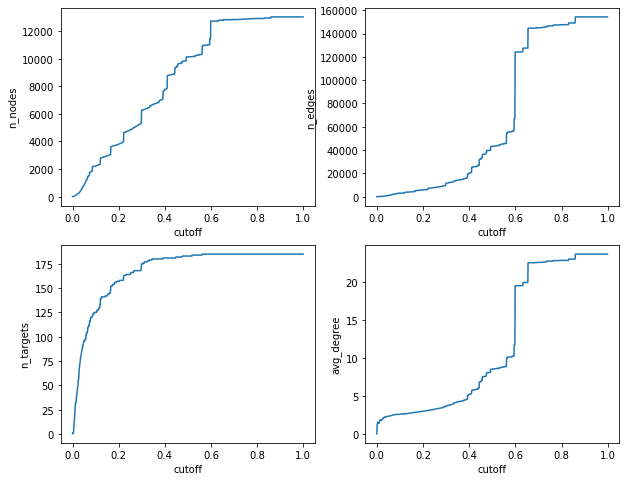

<IPython.core.display.Javascript object>

In [522]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[10, 8])
ax = ax.flatten()
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_nodes", ax=ax[0])
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_edges", ax=ax[1])
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_targets", ax=ax[2])
sns.lineplot(
    data=confidence_cutoff_search_results, x="cutoff", y="avg_degree", ax=ax[3]
)
plt.show()

We see that the average degree and the number of edges jumps at a level around 0.6. Importantly, at this point all 185 ORF targets are already included in the graph. Thus, we will prune the network to remove all edges with a cost higher than the highest edge prize connecting any of the targets, i.e. the minimum cutoff value for which the number of targets that are covered in the respective subgraph are 185.

In [523]:
confidence_cutoff_search_results.loc[
    confidence_cutoff_search_results["n_targets"] == 185
].sort_values("cutoff").head(1)

,cutoff,n_nodes,n_targets,n_edges,avg_degree
562,0.562,10900,185,54582,10.015046


<IPython.core.display.Javascript object>

That is the case for a cutoff of 0.562. At this point the induced subgraph consists of 10'900 nodes and 54'592 edges and an average node degree of 10.02.

In [524]:
filtered_ppi_edge_list = nx.to_pandas_edgelist(filtered_ppi)
pruned_ppi = nx.nx.from_pandas_edgelist(
    filtered_ppi_edge_list.loc[filtered_ppi_edge_list["cost"] < 0.562, :]
)

<IPython.core.display.Javascript object>

The pruned PPI consists of 28 connected components: one large component connecting 10'841 nodes, 5 tripplets and and 22 doublets. Importantly, all 185 ORF targets are covered in the largest connected component.

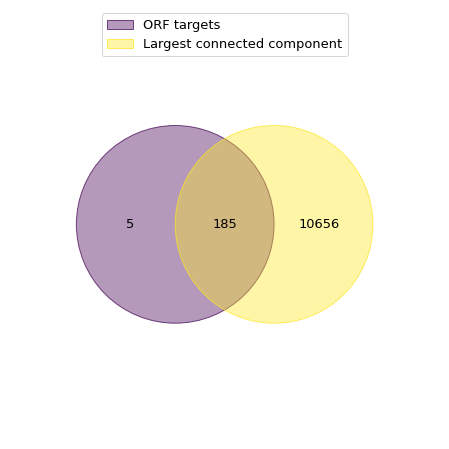

<IPython.core.display.Javascript object>

In [525]:
ccomps = [pruned_ppi.subgraph(c).copy() for c in nx.connected_components(pruned_ppi)]
largest_ccomp = ccomps[0]
ax = venn.venn(
    dict(
        zip(
            [
                "ORF targets",
                "Largest connected component",
            ],
            [orf_targets, set(largest_ccomp.nodes())],
        )
    ),
    legend_loc="upper center",
)

In the following we will only work with that component.

In [526]:
pruned_ppi = largest_ccomp

<IPython.core.display.Javascript object>

This component covers 2'271/2'753 genes that we previously selected based on the their over-expression with a log-fold change of at least 1 compared to other cancer cell lines on the basis of the CCLE data set.

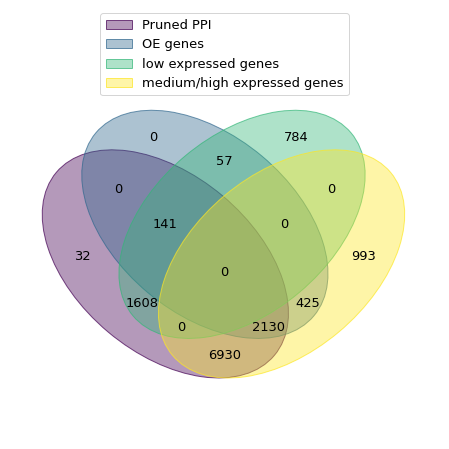

<IPython.core.display.Javascript object>

In [527]:
ax = venn.venn(
    dict(
        zip(
            [
                "Pruned PPI",
                "OE genes",
                "low expressed genes",
                "medium/high expressed genes",
            ],
            [
                set(pruned_ppi.nodes()),
                selected_gene_set,
                background_genes,
                foreground_genes,
            ],
        )
    ),
    legend_loc="upper center",
)

Among those 2'271 genes, 141 correspond to the ones we identified as being low-expressed in the scRNA-seq data set and 2'130 as being high expressed.

However, we will not yet select the network that spans those only those genes, but further prune the PPI by removing any low-expressed genes if they are not part of the ORF targets.

In [528]:
selected_ppi = pruned_ppi.subgraph(
    set(pruned_ppi.nodes()).intersection(foreground_genes.union(orf_targets))
)
print(nx.info(selected_ppi))

Name: 
Type: Graph
Number of nodes: 9068
Number of edges: 45530
Average degree:  10.0419


<IPython.core.display.Javascript object>

The induced subgraph spanning those 9'068 genes consists of 90 connected components, most of them being singeltons and doublets. The largest connected component spanning 8'976 genes including 185/190 ORF targets of which 8 are low expressed in wildtype U2OS cells (corresponding to ORF targets) and the remaining ones highly expressed.

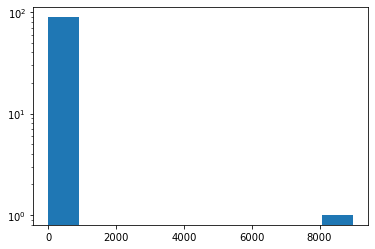

<IPython.core.display.Javascript object>

In [529]:
len_selected_ppi = [
    len(c) for c in sorted(nx.connected_components(selected_ppi), key=len, reverse=True)
]
plt.hist(len_selected_ppi)
plt.yscale("log")

In [530]:
Counter(len_selected_ppi)

Counter({8976: 1, 3: 1, 2: 1, 1: 87})

<IPython.core.display.Javascript object>

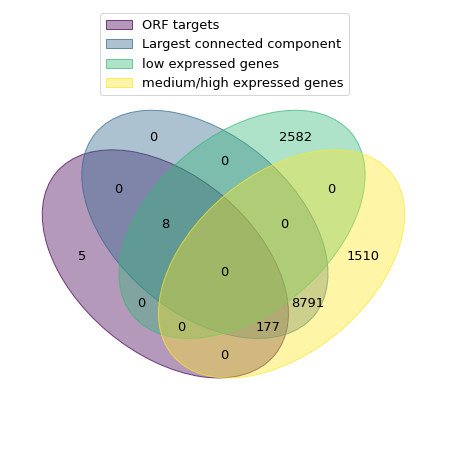

<IPython.core.display.Javascript object>

In [531]:
ccomps = [
    selected_ppi.subgraph(c).copy() for c in nx.connected_components(selected_ppi)
]
largest_ccomp = ccomps[0]
ax = venn.venn(
    dict(
        zip(
            [
                "ORF targets",
                "Largest connected component",
                "low expressed genes",
                "medium/high expressed genes",
            ],
            [
                orf_targets,
                set(largest_ccomp.nodes()),
                background_genes,
                foreground_genes,
            ],
        )
    ),
    legend_loc="upper center",
)

The selected subnetwork of the human PPI would describe 1'352 genes including 179 ORF targets of which 79 were identified as being low expressed in wildtype U2OS cells and 1'273 were identified as being medium or high expressed.

However, an alternative network could be given by simply the largest component of the PPI pruned to remove low-confidence edges. In order to obtain a network that is then specific with respect to the U2OS cell-type one could use the Prize-collecting steiner tree approach by assigning appropriate edge weights and node prizes.

---

## 4. Relationship strength of the between the selected genes

In this section we will look at ways to define the edge costs for the Prize-collecting Steiner tree inference-based derivation of the U2OS-specific interactome. To this end, we will look at three different measures that are often used to describe the association of genes to guide the derivation of regulatory networks and interactomes, namely the Pearson correlation, the Spearman correlation and the normalized mutual information. Since, we want to assign higher costs to for relationships between any pair of genes that we have little evidence for as measured by the three previously mentioned metrics, we compute these as

$$
w_{i,j} = 1-|a_{i,j}|,
$$

where $w_{i,j}$ is the edge weight and $a_{i,j}$ is the respective association of the genes $i$ and $j$ as measured by the metrics.

Those metrics are sensitive to outliers. This is another explanation why we focused on highly expressed genes in the derivation of the base PPI.

We will now compute the respective edge weights for any edge in the base PPI and visualize their distribution.

In [596]:
selected_ppi = compute_edge_weights(pruned_ppi, fucci_data, b=100)

Compute edge weights for spearmanp: 100%|██████████| 54550/54550 [57:37<00:00, 15.78it/s] 


<IPython.core.display.Javascript object>

In [752]:
other_ppi = compute_edge_weights(pruned_ppi, fucci_data, metrics=["mi"])

Compute edge weights for mi: 100%|██████████| 54550/54550 [00:35<00:00, 1550.55it/s]


<IPython.core.display.Javascript object>

### 4.1. Pearson correlation-based edge weights

In [725]:
pearsonr_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "pearson").values())
)

<IPython.core.display.Javascript object>

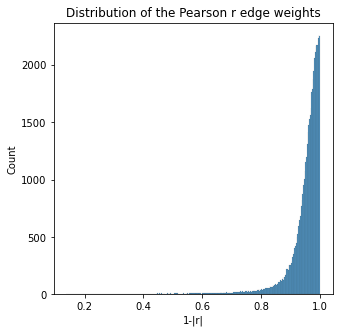

<IPython.core.display.Javascript object>

In [726]:
plt.figure(figsize=[5, 5])
sns.histplot(pearsonr_weights)
plt.title("Distribution of the Pearson r edge weights")
plt.xlabel("1-|r|")
plt.show()

In [616]:
pearsonp_weights = np.array(
    list(nx.get_edge_attributes(pruned_ppi, "pearsonp").values())
)

<IPython.core.display.Javascript object>

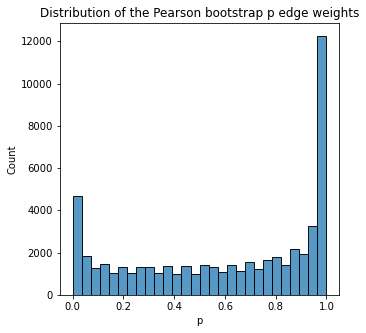

<IPython.core.display.Javascript object>

In [625]:
plt.figure(figsize=[5, 5])
sns.histplot(pearsonp_weights)
plt.title("Distribution of the Pearson bootstrap p edge weights")
plt.xlabel("p")
plt.show()

### 4.2. Spearman correlation-based edge weights

In [727]:
spearmanr_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "spearman").values())
)

<IPython.core.display.Javascript object>

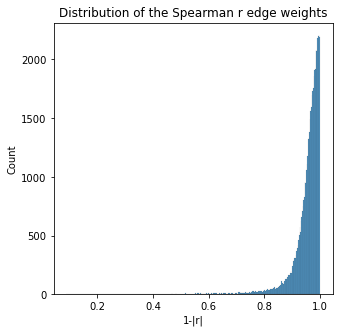

<IPython.core.display.Javascript object>

In [728]:
plt.figure(figsize=[5, 5])
sns.histplot(spearmanr_weights)
plt.title("Distribution of the Spearman r edge weights")
plt.xlabel("1-|r|")
plt.show()

In [729]:
spearmanp_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "spearmanp").values())
)

<IPython.core.display.Javascript object>

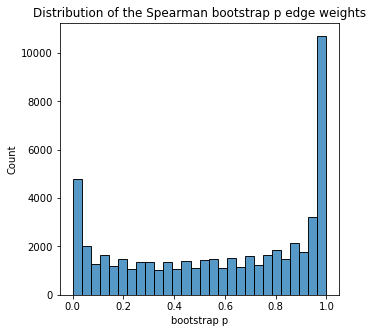

<IPython.core.display.Javascript object>

In [730]:
plt.figure(figsize=[5, 5])
sns.histplot(spearmanp_weights)
plt.title("Distribution of the Spearman bootstrap p edge weights")
plt.xlabel("bootstrap p")
plt.show()

In [753]:
mi_weights = np.array(list(nx.get_edge_attributes(other_ppi, "mi").values()))

<IPython.core.display.Javascript object>

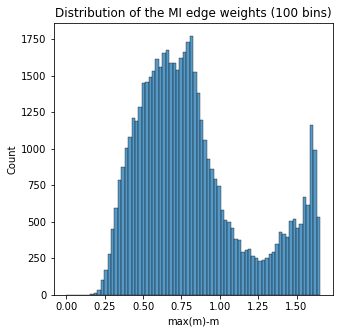

<IPython.core.display.Javascript object>

In [754]:
plt.figure(figsize=[5, 5])
sns.histplot(np.max(mi_weights) - (mi_weights))
plt.title("Distribution of the MI edge weights (100 bins)")
plt.xlabel("max(m)-m")
plt.show()